<a href="https://colab.research.google.com/github/sun-gif/Deep-learning/blob/master/Daily_COVID_predicting_by_County.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#load the data
from google.colab import files
import pandas as pd
uploaded = files.upload()
import io
#train = pd.read_csv(io.BytesIO(uploaded['mergedData.csv']),parse_dates=True)
train = pd.read_csv(io.BytesIO(uploaded['covid_confirmed_usafacts.csv']),parse_dates=True)
#test= pd.read_csv(io.BytesIO(uploaded['test.csv']),parse_dates=True)
# Dataset is now stored in a Pandas Dataframe

Saving covid_confirmed_usafacts.csv to covid_confirmed_usafacts (1).csv


In [0]:

train=train.set_index(['State','stateFIPS','countyFIPS','County Name'])
train.head()

1/22/20  ...  4/2/20
State stateFIPS countyFIPS County Name                     ...        
AL    1         0          Statewide Unallocated        0  ...       0
                1001       Autauga County               0  ...      10
                1003       Baldwin County               0  ...      25
                1005       Barbour County               0  ...       0
                1007       Bibb County                  0  ...       4

[5 rows x 72 columns]

In [0]:
df=train[train.astype(bool)].stack().reset_index().drop(0)
df['Date'] = pd.to_datetime(df['level_4'])

df.sort_values("Date", inplace=True)
df=df.drop(['level_4'],axis=1)
df.head()

,State,stateFIPS,countyFIPS,County Name,0,Date
26729,WA,53,53033,King County,1.0,2020-01-22
26730,WA,53,53033,King County,1.0,2020-01-23
26731,WA,53,53033,King County,1.0,2020-01-24
7012,IL,17,17031,Cook County,1.0,2020-01-24
7013,IL,17,17031,Cook County,1.0,2020-01-25


In [0]:

total_date_WC = df[df['County Name']=='Westchester County'].groupby(['Date']).agg({0:sum})
total_data_KC= df[df['County Name']=='King County'].groupby(['Date']).agg({0:sum})
total_data_KC
#WCNew=total_date_WC.diff()
#WCNew

,0
Date,
2020-01-22,1.0
2020-01-23,1.0
2020-01-24,1.0
2020-01-25,1.0
2020-01-26,1.0
...,...
2020-03-29,2161.0
2020-03-30,2330.0
2020-03-31,2330.0


In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [0]:

WC=total_date_WC.iloc[:,0:1].values
WC
KC=total_data_KC[total_data_KC[0]>1].iloc[:,0:1].values
len(KC)
#total_data_KC[total_data_KC[0]>1]

34

In [0]:
def sliding_windows(data, seq_length):
      
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [0]:

sc = MinMaxScaler()
training_data = sc.fit_transform(KC)

In [0]:
seq_length = 5
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [0]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [0]:
num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
#criterion = nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.31839
Epoch: 100, loss: 0.10293
Epoch: 200, loss: 0.02707
Epoch: 300, loss: 0.01480
Epoch: 400, loss: 0.01361
Epoch: 500, loss: 0.01276
Epoch: 600, loss: 0.01183
Epoch: 700, loss: 0.01081
Epoch: 800, loss: 0.00968
Epoch: 900, loss: 0.00841
Epoch: 1000, loss: 0.00695
Epoch: 1100, loss: 0.00526
Epoch: 1200, loss: 0.00340
Epoch: 1300, loss: 0.00167
Epoch: 1400, loss: 0.00057
Epoch: 1500, loss: 0.00020
Epoch: 1600, loss: 0.00014
Epoch: 1700, loss: 0.00013
Epoch: 1800, loss: 0.00013
Epoch: 1900, loss: 0.00013


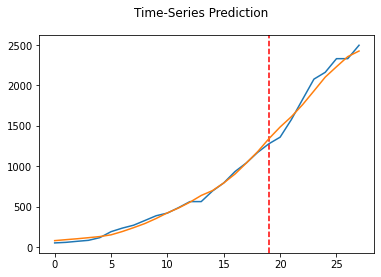

In [0]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [0]:
test_predict=lstm(testX)
test1=test_predict.data.numpy()


In [0]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test1, testY)
print('Test MSE: %.3f' % error)

Test MSE: 0.001


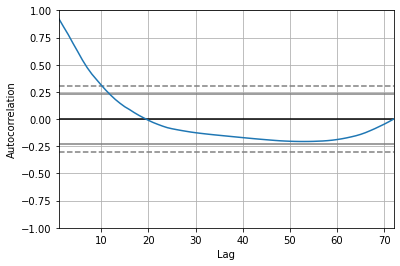

In [0]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
from pandas.plotting import autocorrelation_plot
 
series = total_data_KC.values
autocorrelation_plot(series)
pyplot.show()

In [0]:
sc = MinMaxScaler()
series = sc.fit_transform(total_data_KC.values)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   71
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 204.667
Method:                       css-mle   S.D. of innovations              0.013
Date:                Fri, 15 May 2020   AIC                           -395.335
Time:                        23:23:35   BIC                           -379.496
Sample:                             1   HQIC                          -389.036
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0208      0.018      1.152      0.254      -0.015       0.056
ar.L1.D.y      0.4101      0.119      3.441      0.001       0.177       0.644
ar.L2.D.y      0.4163      0.127      3.287      0.0

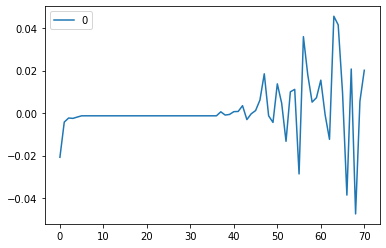

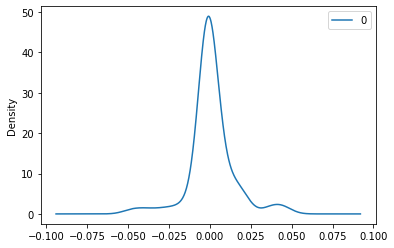

               0
count  71.000000
mean    0.000987
std     0.013572
min    -0.047461
25%    -0.001300
50%    -0.001300
75%     0.002309
max     0.045544


In [0]:



# fit model
model = ARIMA(series,order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [0]:
series=total_data_KC[total_data_KC[0]>1]


predicted=0.440860, expected=0.439245
predicted=0.480050, expected=0.479623
predicted=0.521782, expected=0.510566
predicted=0.542958, expected=0.592830
predicted=0.633394, expected=0.687547


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.750177, expected=0.781509
predicted=0.872408, expected=0.813208


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1826: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)


predicted=0.855053, expected=0.876981


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.923397, expected=0.876981
predicted=0.915612, expected=0.939623
predicted=0.962137, expected=1.000000
Test MSE: 0.001


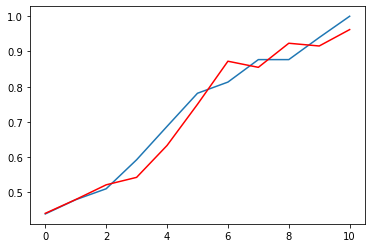

In [0]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 


total_data_KC
X = series.values
sc = MinMaxScaler()
X = sc.fit_transform(X)
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()